In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:

torch.set_default_dtype(torch.float64)

In [3]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

In [4]:
ind_shape = 14

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


In [5]:
ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

In [6]:
list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(len(names_subj)):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))



In [7]:
ind_subj = 1
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]

(-0.05, 1.05, -0.011699000000000001, 0.24567899999999998)

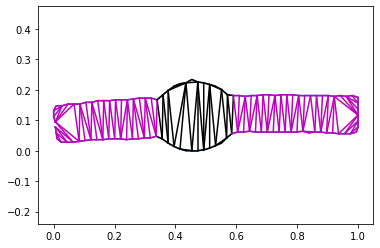

In [8]:
col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

(-0.05, 1.05, -0.012889500000000002, 0.2706795)

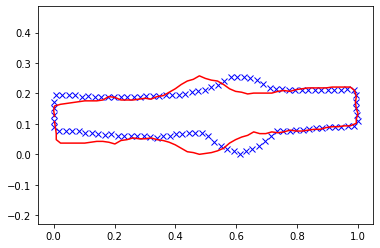

In [9]:
ind_subj = 0
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]
plt.plot(subj[:,0], subj[:,1], 'xb')

ind_subj = 2
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]
plt.plot(subj[:,0], subj[:,1],'r')

plt.axis('equal')

In [10]:
source = torch.tensor(list_subj[0])
target = torch.tensor(list_subj[2])

Matching with LDDMM

In [12]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [13]:
sigma = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma, nu=0.1, gd=source.clone().requires_grad_())

In [14]:
sigmas_varifold = [0.1]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [15]:
# model = dm.Models.RegistrationModel([source_deformable], [rotation], [dm.Attachment.GeomlossAttachment(loss='sinkhorn', blur=0.05, scaling=0.9)], fit_gd=[True], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [translations], [attachment], fit_gd=[False], lam=100.)

In [16]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(4.3638)}
Time: 5.86175776500022
Iteration: 0
Costs
deformation=0.0022633596522434736
attach=0.01299805797541076
Total cost=0.015261417627654233
Time: 11.248502415997791
Iteration: 1
Costs
deformation=0.0018724445665928484
attach=0.0041336712235162665
Total cost=0.006006115790109115
Time: 16.444290029001422
Iteration: 2
Costs
deformation=0.0008687359338754247
attach=0.002639783736402279
Total cost=0.003508519670277704
Time: 21.920995414999197
Iteration: 3
Costs
deformation=0.0003939233119507518
attach=0.0014589143668031213
Total cost=0.001852837678753873
Time: 27.478455025004223
Iteration: 4
Costs
deformation=0.0002435697796312295
attach=0.001107304089220662
Total cost=0.0013508738688518915
Time: 33.257981168004335
Iteration: 5
Costs
deformation=0.00020901796516514196
attach=0.0008562865797756558
Total cost=0.0010653045449407978
Time: 38.59942601399962
Iteration: 6
Costs
deformation=0

In [17]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.05071085408188291,
 1.0502788426839862,
 -0.013582358794930163,
 0.2707124932759491)

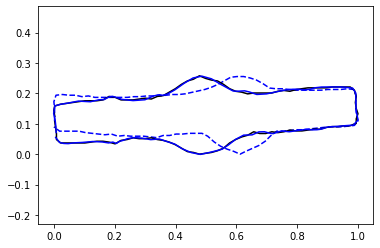

In [18]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], 'b')
plt.axis('equal')

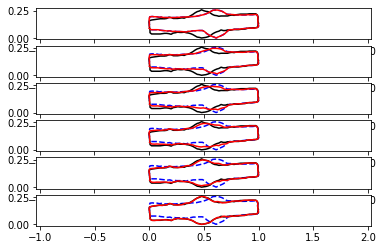

In [19]:
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
    plt.plot(intermediates['states'][2*i].gd[1].detach().numpy()[:,0], intermediates['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

Matching with growth model

In [ ]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [17]:
aabb.scale_([1.5, 2])

In [20]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)


(-0.05, 1.05, -0.012766, 0.268086)

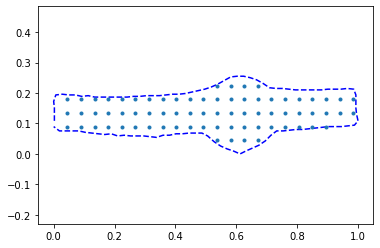

In [21]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.axis('equal')

In [25]:
indi_left0 = range(0, 28)
indi_left1 = range(80, 104)
indi_right = range(37, 69)

part_left = np.concatenate([subj[indi_left1, :], subj[indi_left0, :]], axis = 0)
part_right = subj[indi_right, :]

(-0.05, 1.05, -0.012766, 0.268086)

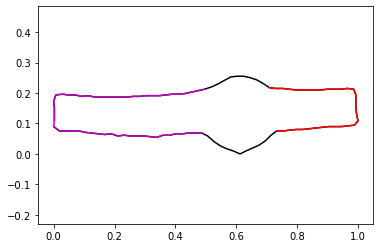

In [26]:
plt.plot(subj[:,0], subj[:,1], 'k')
plt.plot(part_left[:,0], part_left[:,1], 'm')
plt.plot(part_right[:,0], part_right[:,1], 'r')
plt.axis('equal')

In [52]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


In [53]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])

(-0.05, 1.05, -0.012766, 0.268086)

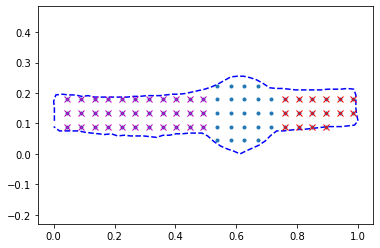

In [54]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], 'xr')
plt.axis('equal')

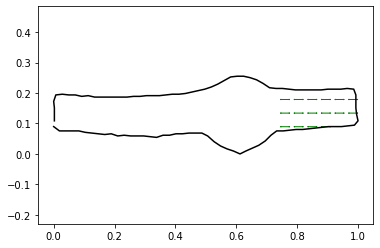

In [31]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 2)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.

ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, c_index=1, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()


In [32]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [33]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [34]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [35]:
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, growth], [attachment], fit_gd=[False], lam=100.)

In [36]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(4.3638)}
Time: 53.098506563997944
Iteration: 0
Costs
deformation=0.003238993971488166
attach=3.6237004590238264
Total cost=3.6269394529953147
Time: 119.64353383000707
Iteration: 1
Costs
deformation=0.24618450712327802
attach=2.5413174255097815
Total cost=2.7875019326330595
Time: 179.36227261800377
Iteration: 2
Costs
deformation=0.18778479512214072
attach=0.8552808715922122
Total cost=1.043065666714353
Time: 225.01674051600276
Iteration: 3
Costs
deformation=0.015574388293331505
attach=0.6809035681746067
Total cost=0.6964779564679382
Time: 274.07408104299975
Iteration: 4
Costs
deformation=0.0014279864025753676
attach=0.6430537765720556
Total cost=0.644481762974631
Time: 295.40859533399635
Iteration: 5
Costs
deformation=1.2149292815166659e-10
attach=0.6409357283008621
Total cost=0.640935728422355
Time: 298.1768165520043
Iteration: 6
Costs
deformation=1.2149292815166659e-10
attach=0.6409

In [37]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = modelgrowth.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.05, 1.05, -0.023968308540186042, 0.27120706231143743)

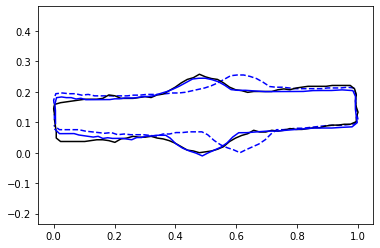

In [38]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], 'b')
plt.axis('equal')

tensor([-0.3198,  0.2507])
tensor([-0.3022,  0.2801])
tensor([-0.2890,  0.3286])
tensor([-0.2791,  0.4165])
tensor([-0.2676,  0.5638])


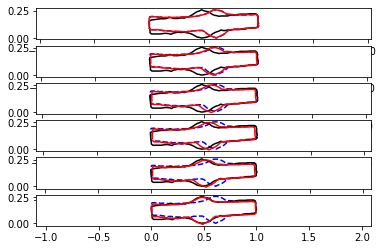

In [51]:
for i in range(6):
    plt.subplot(6,1,i+1)
    if i<5:
        print(intermediates['controls'][2*i][2])
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.axis('equal')